# IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import pickle
# Google services
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
# from google.colab import drive

# LOAD DATA

                   Sales
Month                   
2023-09-01  196088478048
2023-10-01  193806971443
2023-11-01  185357688406
2023-12-01  169696397949
2024-01-01  148097344016
2024-02-01  101453296824
2024-03-01  132078849895
2024-04-01  104406546191
2024-05-01  114427136014
2024-06-01  105953337425
2024-07-01  126744900165
2024-08-01  139829987390
2024-09-01  138905000000
2024-10-01  134309000000
2024-11-01   99099000000
2024-12-01   94011000000


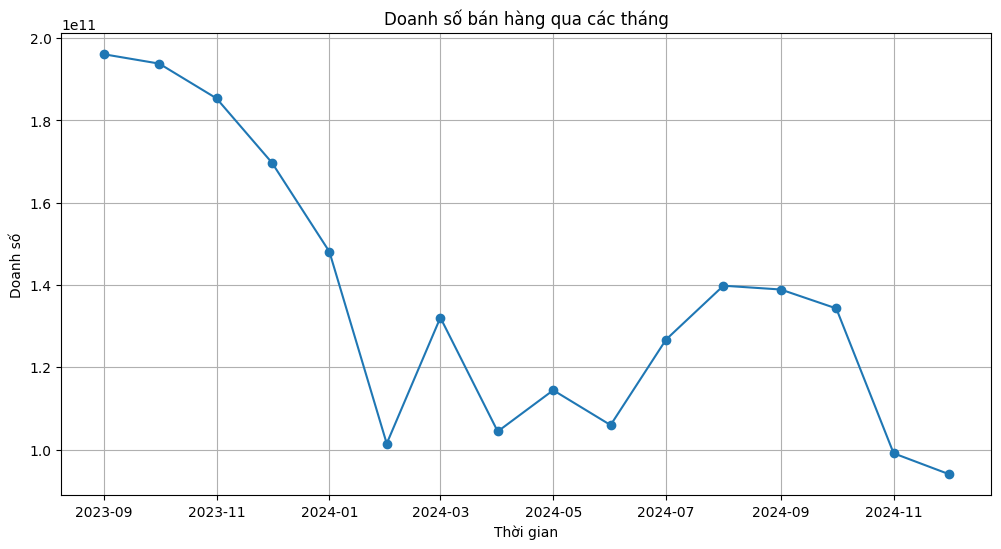

In [2]:
# Spread Sheet
scopes = ['https://www.googleapis.com/auth/spreadsheets',
        'https://www.googleapis.com/auth/drive']
credentials = Credentials.from_service_account_file('/Users/tanhpuh/Documents/GitHub/codev2/code/Python/Pandas Google Spreadsheets/service_account.json', scopes=scopes)
gc = gspread.authorize(credentials)
gauth = GoogleAuth()
drive = GoogleDrive(gauth)
# open a google sheet
gs = gc.open_by_key('1R0_tAkBd4w6lR6krI0Zb4Cn1Hc3O_-xygPIE9K_iaZ0')
# select a work sheet from its name
worksheet1 = gs.worksheet('Sheet1')
# get all the records of the data
data = worksheet1.get_all_records()
df = pd.DataFrame(data)
# Rename columns and keep only Month and Sales
df = df.rename(columns={'date_key': 'Month', 'nmv': 'Sales'})
df = df[['Month', 'Sales']]
# Convert Month to datetime and set as index
df['Month'] = pd.to_datetime(df['Month']) #format='%Y'
df.set_index('Month', inplace=True)
print(df)

# Dữ liệu gồm cột 'Month' và 'Sales'
# data = {
#     'Month': pd.date_range(start='2020-01-01', periods=36, freq='M'),
#     'Sales': [200, 220, 230, 240, 250, 260, 280, 300, 320, 350, 400, 420,
#               440, 450, 470, 480, 500, 520, 530, 550, 570, 590, 600, 620,
#               630, 640, 660, 670, 680, 700, 720, 750, 770, 780, 800, 820]
# }
# df = pd.DataFrame(data)
# df.set_index('Month', inplace=True)
# print(df)

# Colab
# file_path = "/content/drive/My Drive/Colab Notebooks/Data/Tqvahq.csv"
# data = pd.read_csv(file_path)
# df = pd.DataFrame(data)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(df['Sales'], marker='o', linestyle='-')
plt.title('Doanh số bán hàng qua các tháng')
plt.xlabel('Thời gian')
plt.ylabel('Doanh số')
plt.grid()
plt.show()

# INPUT

In [14]:
freq = 4 # input frequency seasonal
lags_1 = 14
lags_2 = 8

# SEASONALITY & STATIONATIRY

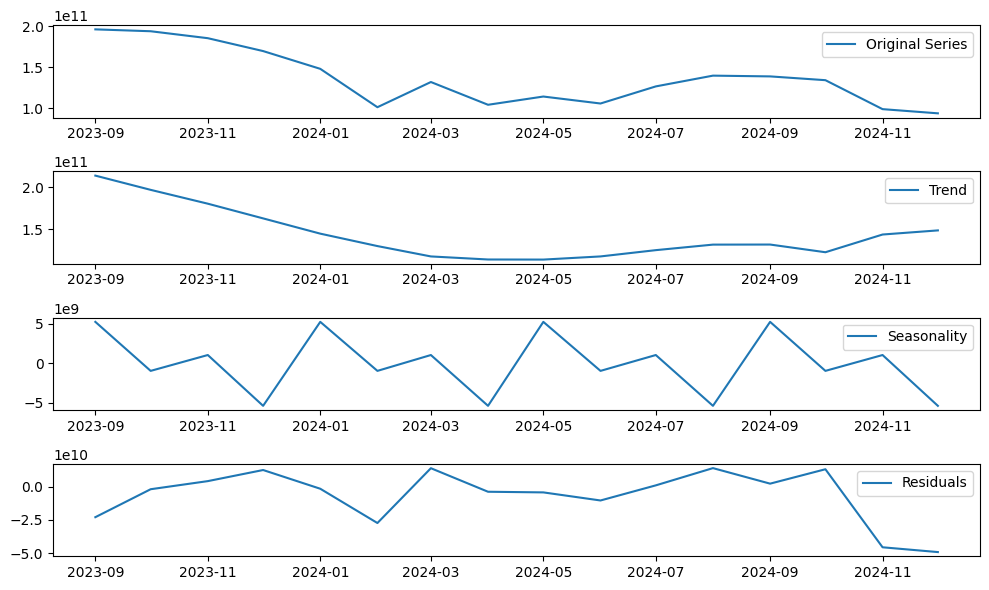

ADF Statistic: -2.060549808209024
p-value: 0.2606705995566424
Dữ liệu có tính dừng


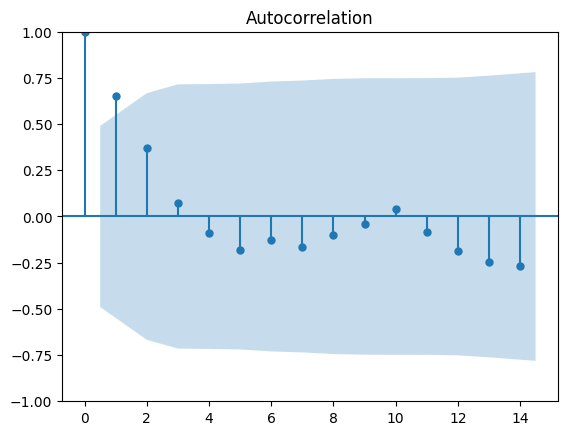

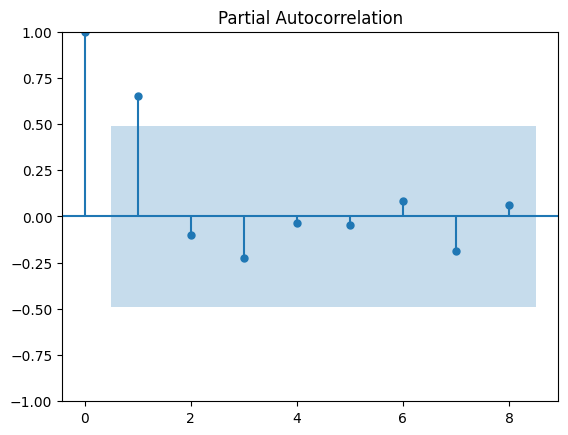

Có tính chu kỳ (seasonality_strength=0.12), nên dùng seasonal=True.
Seasonal = True


In [15]:
def check_seasonality(time_series, freq=None):
    """
    Kiểm tra xem chuỗi thời gian có tính chu kỳ không.
    
    Params:
        time_series: Chuỗi dữ liệu dạng pandas Series.
        freq: Tần suất chu kỳ (nếu biết trước, có thể đặt, ví dụ: 12 cho dữ liệu hàng tháng).
    
    Returns:
        True nếu có seasonality, False nếu không.
    """
    # Bước 1: Phân rã chuỗi thời gian (Seasonal Decomposition)
    decomposition = seasonal_decompose(time_series, period=freq, model='additive', extrapolate_trend='freq')
    seasonal_component = decomposition.seasonal

    # Vẽ thành phần chu kỳ
    plt.figure(figsize=(10, 6))
    plt.subplot(411)
    plt.plot(time_series, label='Original Series')
    plt.legend()
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()
    plt.subplot(413)
    plt.plot(seasonal_component, label='Seasonality')
    plt.legend()
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Bước 2: Kiểm tra ADF Test (Stationarity Test)
    adf_result = adfuller(time_series.dropna())
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    
    if adf_result[1] > 0.05:
        print("Dữ liệu có tính dừng")
    else:
        print("Dữ liệu không có tính dừng")

    # Bước 3: Kiểm tra Auto-Correlation Function (ACF)
    plot_acf(time_series.dropna(), lags=lags_1)
    plt.show()

    plot_pacf(time_series.dropna(), lags=lags_2)
    plt.show()

    # Bước 4: Đánh giá độ biến động của thành phần chu kỳ
    seasonality_strength = np.std(seasonal_component) / np.std(time_series)
    
    if seasonality_strength > 0.1:
        print(f"Có tính chu kỳ (seasonality_strength={seasonality_strength:.2f}), nên dùng seasonal=True.")
        return True
    else:
        print(f"Không có tính chu kỳ rõ ràng (seasonality_strength={seasonality_strength:.2f}), nên dùng seasonal=False.")
        return False

# Kiểm tra seasonality
should_use_seasonal = check_seasonality(df['Sales'], freq=freq) # freq=freq
print(f"Seasonal = {should_use_seasonal}")

# BUILDING AN ARIMA MODEL

## Automatically select the best parameters using auto_arima:
auto_arima sẽ tự xử lý differencing nếu dữ liệu có stationarity = false

In [16]:
# Dùng auto_arima để chọn tham số
if should_use_seasonal == True:
  model_auto = auto_arima(df['Sales'], seasonal=True, m=freq, trace=True, suppress_warnings=True, stepwise=True)
else:
  model_auto = auto_arima(df['Sales'], seasonal=False, trace=True, suppress_warnings=True, stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=824.488, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=815.252, Time=0.01 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=830.697, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=868.788, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=813.309, Time=0.00 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=815.295, Time=0.01 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=815.959, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=817.815, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=829.500, Time=0.00 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=818.843, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=inf, Time=0.00 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 0.182 seconds
                               SARIMAX Results 

/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/sklearn/ut

## Training ARIMA model:

In [17]:
# Xây dựng mô hình với tham số từ auto_arima
if should_use_seasonal == True:
  model = SARIMAX(df['Sales'], order=model_auto.order, seasonal_order=model_auto.seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
  model_fit = model.fit()
else:
  model = ARIMA(df['Sales'], order=model_auto.order)
  model_fit = model.fit()

# Tóm tắt kết quả mô hình
print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35390D+01    |proj g|=  2.54340D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   2.538D-04   2.354D+01
  F =   23.539044048047195     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   16
Model:               SARIMAX(1, 0, 0

/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/tanhpuh/Documents/GitHub/codev2/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


# FORECAST AND ASSESSMENT

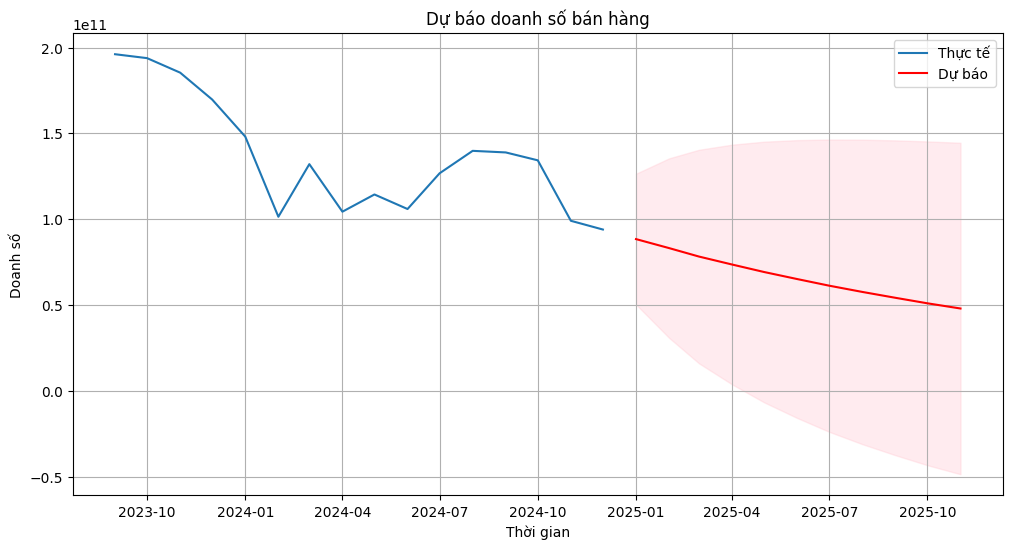

                Forecast   Lower Bound   Upper Bound
2024-12-01           NaN           NaN           NaN
2025-01-01  8.844321e+10  5.038810e+10  1.264983e+11
2025-02-01  8.320516e+10  3.095649e+10  1.354538e+11
2025-03-01  7.827734e+10  1.611359e+10  1.404411e+11
2025-04-01  7.364138e+10  3.867823e+09  1.434149e+11
2025-05-01  6.927997e+10 -6.594670e+09  1.451546e+11
2025-06-01  6.517687e+10 -1.571463e+10  1.460684e+11
2025-07-01  6.131677e+10 -2.376853e+10  1.464021e+11
2025-08-01  5.768529e+10 -3.094639e+10  1.463170e+11
2025-09-01  5.426889e+10 -3.738715e+10  1.459249e+11
2025-10-01  5.105482e+10 -4.319703e+10  1.453067e+11
2025-11-01  4.803110e+10 -4.845995e+10  1.445221e+11


In [18]:
# Dự báo cho tương lai (12 tháng tiếp theo)
forecast = model_fit.get_forecast(steps=12)
forecast_index = pd.date_range(df.index[-1], periods=12, freq='MS')  #freq='M' last day of monthly, 'MS' first day of monthly, 'YS' yearly

forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean,
    'Lower Bound': forecast.conf_int()['lower Sales'],
    'Upper Bound': forecast.conf_int()['upper Sales']
}, index=forecast_index)

# Vẽ biểu đồ dự báo
plt.figure(figsize=(12, 6))
plt.plot(df['Sales'], label='Thực tế')
plt.plot(forecast_df['Forecast'], label='Dự báo', color='red')
plt.fill_between(forecast_df.index, 
                 forecast_df['Lower Bound'], 
                 forecast_df['Upper Bound'], color='pink', alpha=0.3)
plt.title('Dự báo doanh số bán hàng')
plt.xlabel('Thời gian')
plt.ylabel('Doanh số')
plt.legend()
plt.grid()
plt.show()

print(forecast_df)

# MODEL EVALUATION

In [19]:
# Tính toán MAE và RMSE
actual_values = df['Sales'][-12:-1]  # Exclude the last point
forecast_values = forecast_df['Forecast'][1:12]  # Skip first forecast and take next 11 values

mae = mean_absolute_error(actual_values, forecast_values)
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 55902145164.585014
RMSE: 59669351542.0317


# MODEL DEPLOYMENT

In [20]:
# Lưu mô hình
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

# Tải lại mô hình khi cần
with open('arima_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Dự báo lại với mô hình đã lưu
forecast_loaded = loaded_model.get_forecast(steps=12)
print(forecast_loaded.predicted_mean)

2025-01-01    8.844321e+10
2025-02-01    8.320516e+10
2025-03-01    7.827734e+10
2025-04-01    7.364138e+10
2025-05-01    6.927997e+10
2025-06-01    6.517687e+10
2025-07-01    6.131677e+10
2025-08-01    5.768529e+10
2025-09-01    5.426889e+10
2025-10-01    5.105482e+10
2025-11-01    4.803110e+10
2025-12-01    4.518646e+10
Freq: MS, Name: predicted_mean, dtype: float64


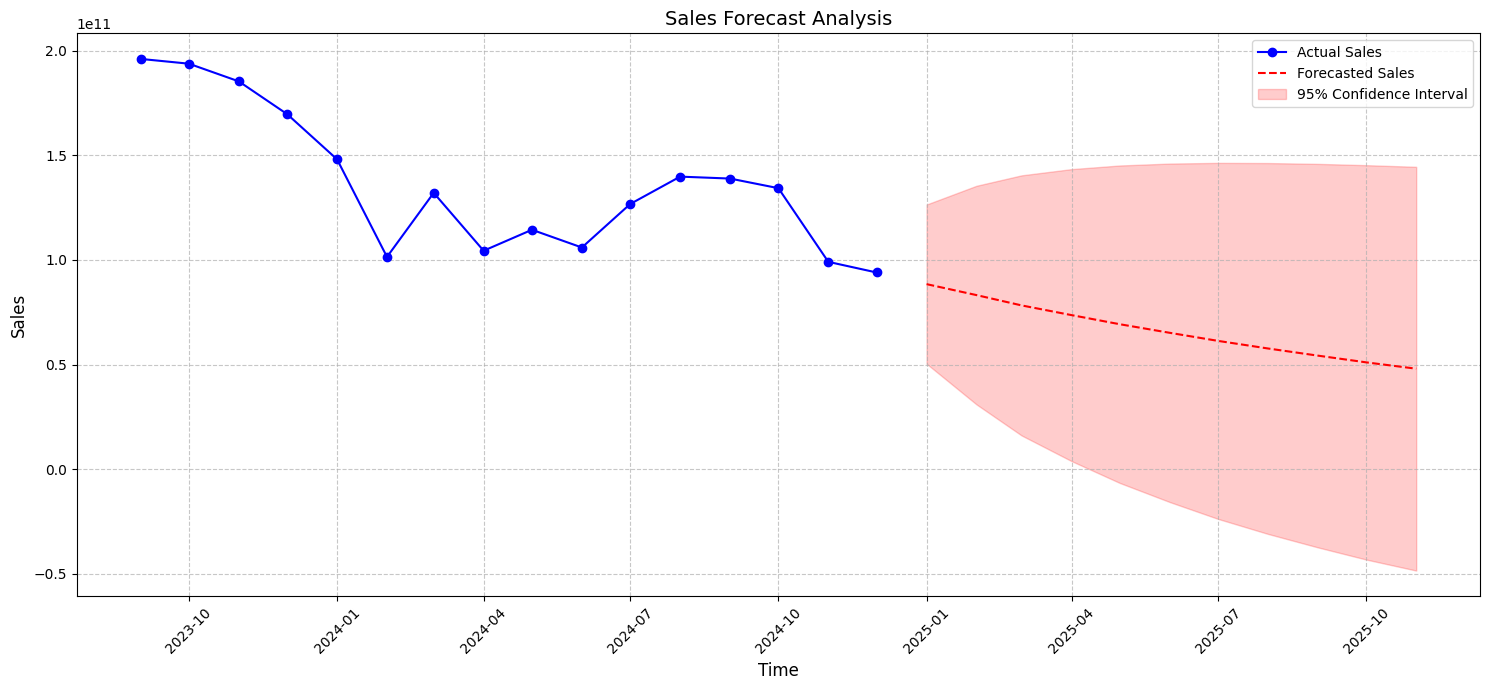

In [21]:
plt.figure(figsize=(15, 7))

# Plot actual values
plt.plot(df.index, df['Sales'], label='Actual Sales', color='blue', marker='o')

# Plot forecasted values
plt.plot(forecast_df.index[1:], forecast_df['Forecast'][1:], label='Forecasted Sales', color='red', linestyle='--')

# Add confidence intervals
plt.fill_between(forecast_df.index[1:], 
         forecast_df['Lower Bound'][1:], 
         forecast_df['Upper Bound'][1:], 
         color='red', alpha=0.2, label='95% Confidence Interval')

plt.title('Sales Forecast Analysis', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()